In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore')

* delays_one - число просрочек (1-6)
* maxdelay_one - максимальное число дней просрочки (в днях)
* DaysInCollection_one - среднее число дней до выплаты после назначения платежа???
* MA_Proposed_Amount - предварительная сумма кредита
* MA_Installment_Amount - ежемесячный платеж
* Proposed_Term - предварительный срок кредита
* TOT_INCOME - общая прибыль
* PTI - Payment to Income Ratio (MA_Installment_Amount/TOT_INCOME)
* curr_del_cap_share_one
* curr_rep_cap_share_one
* PARTWH_INCOME
* PAYMD2TOTPAYM

In [2]:
data = pd.read_excel('data/DEFAULT_AVG_TIME.xls')
data.shape

(18309, 31)

In [3]:
data.head(5).T

,0,1,2,3,4
nnkd,1-RUR-4520-3628260,1-RUR-0000-3984007,1-RUR-0000-3984007,1-RUR-4200-4318552,1-RUR-0000-5015962
mob,11,8,6,8,6
MOB_term,0.180328,0.666667,0.5,0.131148,0.162162
Credit_TermApr,61,12,12,61,37
curr_del_cap_share_one,0.915465,0.530209,0.69376,0.943592,0.919673
curr_rep_cap_share_one,0.0845347,0.469791,0.30624,0.0564078,0.0803272
bad,0,0,0,1,1
maxdelay_one,27,16,16,29,48
DaysInCollection_one,17,18,4,32,32
delays_one,0,0,0,0,1


Первое, что бросается в глаза это наличие совпадающих значений в 'nnkd', переменной являющейся id (в данном случае вероятнее всего номер договора). Для совпадающих значений в 'nndk' совпадают и значения в описательных признаках клиента (MA_). Таким образом, у нас есть клиенты, которые несколько раз присутствуют в датасете, однако они не являются дубликатами, поскольку некоторые признаки для них отличаются. Например, 'mob'. Посмотрим на число уникальных клиентов.

In [7]:
vc = data['nnkd'].value_counts()
print(len(vc))

5003


Проверим на наличие пропусков:

In [14]:
data.isnull().sum()

nnkd                        0
mob                         0
MOB_term                    0
Credit_TermApr              0
curr_del_cap_share_one      0
curr_rep_cap_share_one      0
bad                         0
maxdelay_one                0
DaysInCollection_one        0
delays_one                  0
MA_AGE                      0
MA_Gender                   0
MA_Education                0
MA_Marital_Status           0
MANUMBEROFCHILD             0
MA_Residential_Status       0
MA_MONTH_AT_CURR_ADDRESS    0
MA_Real_Estate_Owner        0
MA_REG_Same_Fact_Addr       0
MA_MONTH_AT_CURR_PASSP      0
MA_Exp_IND                  0
MA_Exp_Month_Paym           0
MA_MONTH_AT_CURR_JOB        0
MA_Time_Previous_Job        0
MA_Installment_Amount       0
MA_Proposed_Amount          0
MA_Proposed_Term            0
TOT_INCOME                  0
PARTWH_INCOME               0
PAYMD2TOTPAYM               0
PTI                         0
dtype: int64

В данных могут присутствовать несколько записей по одному клиенту для которых отличаются текущие месяцы платежа ('mob'). Но есть и те, в которых они совпадают. Интересно посмотреть на эти записи, насколько сильно они отличаются. Рассмотрим одну пару: 

In [87]:
data.iloc[[11784, 12302]].T

,11784,12302
nnkd,1-RUR-0000-3679394,1-RUR-0000-3679394
mob,11,11
MOB_term,0.297297,0.297297
Credit_TermApr,37,37
curr_del_cap_share_one,0.808263,0.839856
curr_rep_cap_share_one,0.191737,0.160144
bad,0,0
maxdelay_one,63,63
DaysInCollection_one,20,20
delays_one,1,1


Будем сравнивать со средним значением по столбцам. Если значения в строках совпадают, то они будут равны среднему по этим строкам. 

In [120]:
tt = data.iloc[[11784, 12302]]
(tt==tt.mean()).T

,11784,12302
Credit_TermApr,True,True
DaysInCollection_one,True,True
MANUMBEROFCHILD,True,True
MA_AGE,True,True
MA_Education,True,True
MA_Exp_IND,True,True
MA_Exp_Month_Paym,True,True
MA_Gender,True,True
MA_Installment_Amount,True,True
MA_MONTH_AT_CURR_ADDRESS,True,True


Записи полностью совпадают, заисключением признаков curr_del_cap_share_one и curr_rep_cap_share_one.

In [8]:
%%time
indx = vc[(vc>1) == True].index
indx_to_drop = []
dll = pd.DataFrame([])
# иттерируемся по номерам договора, которые встречаются больше 1 раза
for i in indx:
    temp_data = data[(data['nnkd']== i)] 
    temp_data['freq']= temp_data['mob'].map(temp_data['mob'].value_counts()) # частота mob для одного договора i

    tt = temp_data[temp_data['freq']>1] # смотрим только повторяющиеся mob
    if tt.shape[0] > 0:
        [indx_to_drop.append(x) for x in tt[1:].index] # отбрасываем все кроме первого
        nnkd = tt['nnkd'].iloc[0]
        tt = tt.groupby('mob').mean() # выводим средние значения, сгруппированные по mob
        tt['mob'] = tt.index
        tt.index = [nnkd]*tt.shape[0]
        
        dll = pd.concat([dll, tt])

Wall time: 11.1 s


Рассмотрим усредненные значения признаков по совпадающим mob. Для таргетной переменной bad, при различных ее значениях, мы получили бы дробные значения средних. Значение mob в столбце "mob".

In [28]:
dll.head(3)

,MOB_term,Credit_TermApr,curr_del_cap_share_one,curr_rep_cap_share_one,bad,maxdelay_one,DaysInCollection_one,delays_one,MA_AGE,MA_Gender,...,MA_Time_Previous_Job,MA_Installment_Amount,MA_Proposed_Amount,MA_Proposed_Term,TOT_INCOME,PARTWH_INCOME,PAYMD2TOTPAYM,PTI,freq,mob
1-RUR-0000-3143488,0.189189,37,0.874417,0.125583,0,76,16,1,30,1,...,84,8187.06,200000,36,63000.0,0.0,0.564082,0.129953,2,7
1-RUR-4500-3230685,0.250000,24,0.850387,0.149613,1,18,32,0,53,0,...,12,10574.22,200000,24,40000.0,0.0,0.607934,0.264355,2,6
1-RUR-4500-3230685,0.291667,24,0.814450,0.185550,1,58,32,0,53,0,...,12,10574.22,200000,24,40000.0,0.0,0.642169,0.264355,2,7


In [13]:
dll['bad'].value_counts()

1    234
0    157
Name: bad, dtype: int64

Таким образом, делаем вывод что при совпадающих значениях mob, таргетная переменная bad не меняется. Можно заметить, что и другие переменные совпадают, за исключением curr_del_cap_share_one и curr_rep_cap_share_one, которые по значениям близки друг к другу. Здесь два варианта: либо просто выбрасываем все кроме первой записи, либо оставляем одну запись и  заменяем curr_del_cap_share_one и curr_rep_cap_share_one на средние значения.

In [16]:
data.shape

(18309, 31)

In [102]:
clean_data = data.drop(indx_to_drop, axis=0)

In [48]:
clean_data.shape

(17833, 31)

Посмотрим на попарные корреляции:

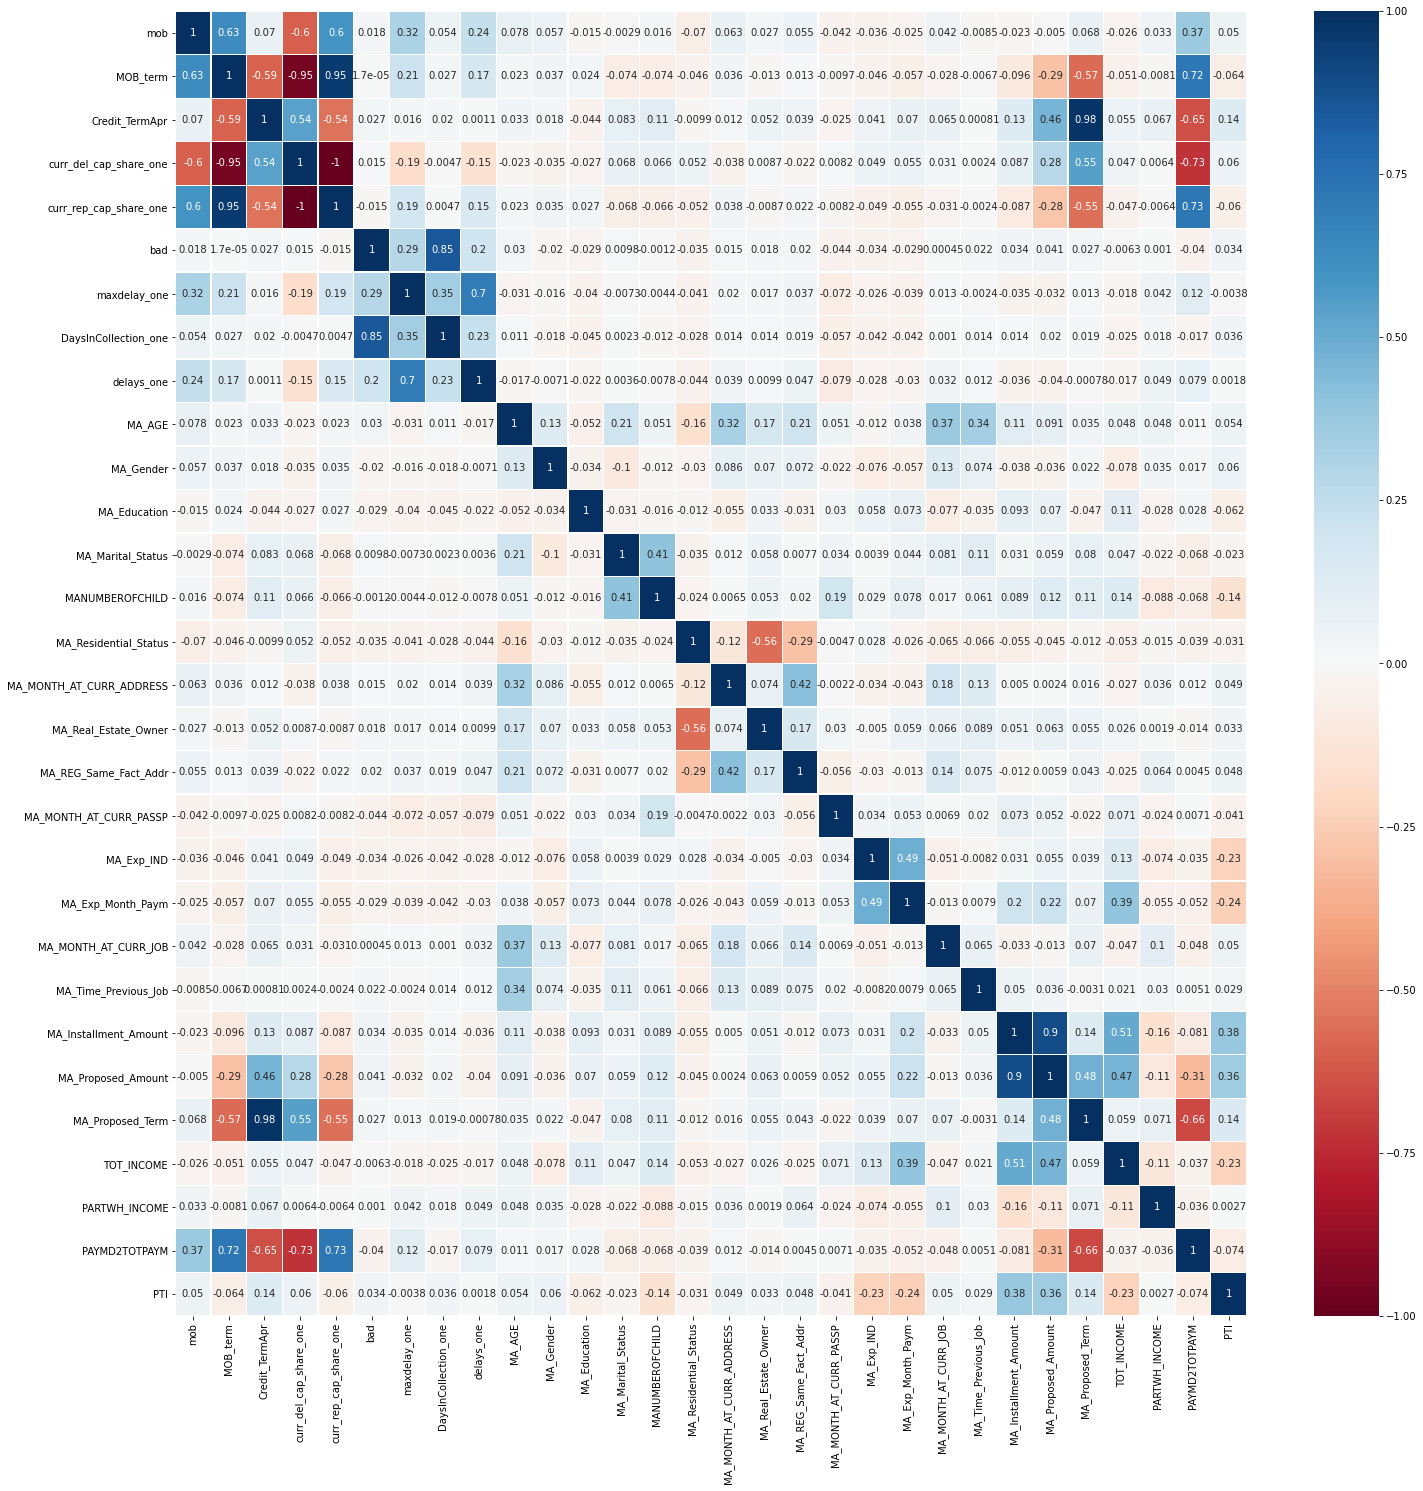

In [76]:
plt.figure(figsize=(24,24))
sns.heatmap(clean_data.corr(),cmap='RdBu', annot=True, linewidths=0.2)
plt.show()

У переменных curr_del_cap_share_one и curr_rep_cap_share_one взаимная корреляция -1, поскольку две переменные в сумме дают 1. У этих же двух переменных 0.95 корреляция с mob_term, т.е. зависимость у них почти линейная. Так же сильная корреляция с признаком PAYMD2TOPAYM. Учитывая крайне слабую корреляцию с целевой переменной (0.015), можем просто от них избавиться, беря вместо них их отношение. 

Очевидно, что у признаков MA_Proposed_term и Credit_TermApr высокая корреляция, поскольку они обозначают реальный и одобренный срок кредита. 

Сильная корреляция (0.9) у признаков MA_Installment_Amount и MA_Proposed_Amount.



In [103]:
clean_data['ratio_curr_cap_share'] = clean_data['curr_rep_cap_share_one']/clean_data['curr_del_cap_share_one']

clean_data['larger_diff_term'] = ((clean_data['Credit_TermApr']-clean_data['MA_Proposed_Term'])>=0).astype(int) # либо > 0

clean_data.drop(['curr_del_cap_share_one', 'curr_rep_cap_share_one', 'MA_Proposed_Term'], axis=1, inplace=True)


In [ ]:
mod = sm.OLS(data['bad'], data.drop(['bad', 'nnkd'], axis=1)).fit()
mod.summary()

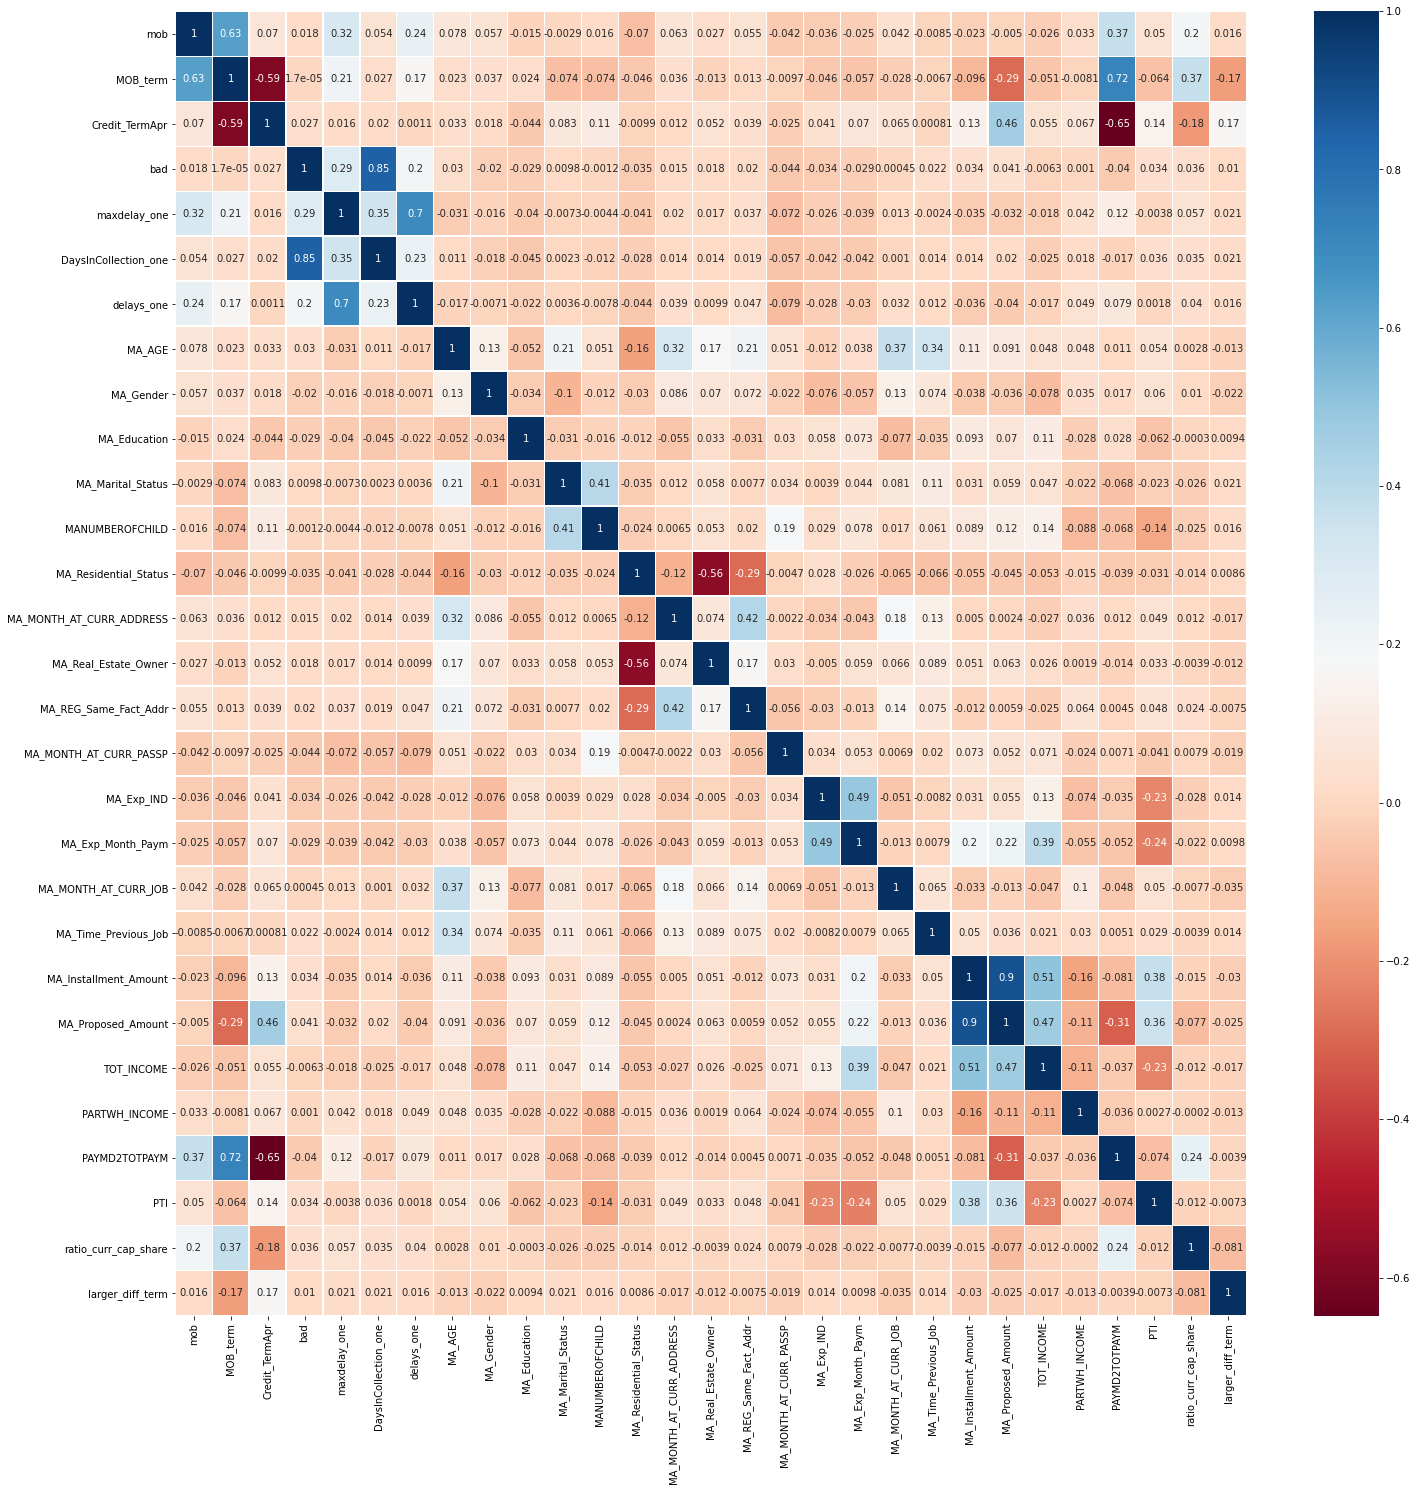

In [104]:
plt.figure(figsize=(24,24))
sns.heatmap(clean_data.corr(),cmap='RdBu', annot=True, linewidths=0.2)
plt.show()